In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, least_squares
import pandas as pd
import warnings

# Seed for reproducibility
np.random.seed(123)

# Daten einlesen
fn = "kineticsAlAcAc_dm_0"
dat0 = pd.read_csv("T_XAlacac3_tau_Data_Neu.csv", sep=";",encoding = "utf-8")
dat0.columns = dat0.columns.str.strip()
print("Spaltennamen:", dat0.columns.tolist())
anfang = 0
ende = 4
all_temp = dat0['Centerline T in K'].values[anfang:ende]
all_times = dat0['Mean Residence Time ms'].values[anfang:ende] / 1000
all_x = (dat0['XAlacac3'] / dat0['XAlacac3'][0]).values[anfang:ende]


# Parameter als Dictionary (Skalierung für bessere Stabilität)
parameters = {
    "As": 3.3e4,
    "Eas": 1.4e4,
    "Ag": 5.8e7,
    "Eag": 4.98e4
}


# Arrhenius-Funktion
def k_arrhenius(A, Ea, T):
    return A * np.exp(-Ea / (8.314 * T))


# x_t Funktion mit Interpolation
def x_t(t, As, Eas, Ag, Eag):
    temp = np.interp(t, all_times, all_temp)
    return np.exp(-t * (k_arrhenius(As, Eas, temp) + k_arrhenius(Ag, Eag, temp)))


# Least-Squares Funktion
def xt_ls(para, t, x, temp):
    As, Eas, Ag, Eag = para
    x_c = np.exp(-t * (k_arrhenius(As, Eas, temp) + k_arrhenius(Ag, Eag, temp)))
    return x - x_c


# Kovarianz und Fehleranalyse
def calculate_covariance(loesls, num_params, num_meas):
    RSS = sum(loesls.fun ** 2)
    SER = np.sqrt(RSS / (num_meas - num_params))
    q, r = np.linalg.qr(loesls.jac)
    r_inv = np.linalg.pinv(r)
    jtj_inv = np.matmul(r_inv, r_inv.T)
    return SER ** 2 * jtj_inv, SER

lower_bounds = [1e3, 1e4, 1e6, 4e4]    # Untere Grenzen der Parameter [As, Eas, Ag, Eag]
upper_bounds = [1e6, 5e4, 1e9, 8e4]    # Obere Grenzen der Parameter [As, Eas, Ag, Eag]

# Fit-Berechnung und Ausgabe der Ergebnisse
initial_params = list(parameters.values())
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    curve_fit_params, curve_fit_cov = curve_fit(x_t, all_times, all_x, p0=initial_params, bounds=(lower_bounds,upper_bounds))

# Ergebnis des Curve Fit prüfen
print("Curve Fit Ergebnisse:")
if curve_fit_cov is not None:
    As, Eas, Ag, Eag = curve_fit_params
    print(f"Oberfläche: A = {As:.2e}, Ea = {Eas:.2e}")
    print(f"Gasphase: A = {Ag:.2e}, Ea = {Eag:.2e}")
    stdev = np.sqrt(np.diag(curve_fit_cov))
    print("Sigma (Curve Fit):", stdev)
else:
    print("Curve Fit Kovarianz konnte nicht berechnet werden.")

# Least Squares Fit und Ergebnisse
least_squares_result = least_squares(xt_ls, initial_params,bounds=(lower_bounds, upper_bounds), loss='linear', method='trf',
                                     args=(all_times, all_x, all_temp),)
print("\nLeast Squares Fit Ergebnisse:")
As_ls, Eas_ls, Ag_ls, Eag_ls = least_squares_result.x
print(f"Oberfläche: A = {As_ls:.2e}, Ea = {Eas_ls:.2e}")
print(f"Gasphase: A = {Ag_ls:.2e}, Ea = {Eag_ls:.2e}")

# Kovarianz und Fehlerberechnung für Least Squares
cov_matrix, ser = calculate_covariance(least_squares_result, len(initial_params), len(all_temp))
std_residuals = np.sqrt(np.diag(cov_matrix))
print("Kovarianzmatrix (Least Squares Fit):\n", cov_matrix)
print("Standardabweichungen (Least Squares Fit):", std_residuals)
print("Standardfehler der Regression (SER):", ser)

# Korrelationsmatrix berechnen und anzeigen
print("\nKorrelationsmatrix:")
for i in range(4):
    for j in range(i):
        correlation = cov_matrix[i, j] / (std_residuals[i] * std_residuals[j])
        print(f"Parameter {j} und {i}: {correlation:.3f}")

# Plot der Ergebnisse
fig1, ax1 = plt.subplots()
ax1.plot(all_times, all_x, "bs", label="Messdaten")
ax1.plot(all_times, x_t(all_times, *curve_fit_params), "k--", label="Curve Fit")
ax1.plot(all_times, x_t(all_times, *least_squares_result.x), "b--", label="Least Squares Fit")
ax1.set_xlabel("Verweilzeit (s)")
ax1.set_ylabel("(x/x$_0$)")
ax1.legend()
fig1.savefig(fn + "_x-T.png")
plt.show()

# Arrhenius-Plot
fig2, ax2 = plt.subplots()
ax2.plot(1000 / all_temp, np.log10(-np.log(all_x) / all_times), "bs", label="Messdaten")


def plot_arrhenius(ax, params, color, label):
    As, Eas, Ag, Eag = params
    ks = np.log10(k_arrhenius(As, Eas, all_temp))
    kg = np.log10(k_arrhenius(Ag, Eag, all_temp))
    k_tot = np.log10(k_arrhenius(Ag, Eag, all_temp) + k_arrhenius(As, Eas, all_temp))

    ax.plot(1000 / all_temp, ks, color + "-", label=f"{label} Oberfläche")
    ax.plot(1000 / all_temp, kg, color + ".-", label=f"{label} Gas")
    ax.plot(1000 / all_temp, k_tot, color + ":", label=f"{label} Gesamt")


plot_arrhenius(ax2, curve_fit_params, "k", "Curve Fit")
plot_arrhenius(ax2, least_squares_result.x, "b", "Least Squares Fit")
ax2.set_xlabel("1000 / $T$ / (1000/K)")
ax2.set_ylabel("log$_{10}(k /$s)")
ax2.legend()
fig2.savefig(fn + "_Arrhenius.png")
plt.show()



Spaltennamen: ['Centerline T in K;XAlacac3;Mean Residence Time ms']


KeyError: 'Centerline T in K'

Spaltennamen: ['T', 'X', 'MeanTime (ms)']
Curve Fit Ergebnisse:
Oberfläche: A = 3.30e+04, Ea = 1.40e+04
Gasphase: A = 5.80e+07, Ea = 4.98e+04
Sigma (Curve Fit): [inf inf inf inf]

Least Squares Fit Ergebnisse:
Oberfläche: A = 3.30e+04, Ea = 1.40e+04
Gasphase: A = 5.80e+07, Ea = 4.98e+04
Kovarianzmatrix (Least Squares Fit):
 [[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
Standardabweichungen (Least Squares Fit): [nan nan nan nan]
Standardfehler der Regression (SER): inf

Korrelationsmatrix:
Parameter 0 und 1: nan
Parameter 0 und 2: nan
Parameter 1 und 2: nan
Parameter 0 und 3: nan
Parameter 1 und 3: nan
Parameter 2 und 3: nan


C:\Users\adako\AppData\Local\Temp\ipykernel_14880\1415417753.py:65: OptimizeWarning: Covariance of the parameters could not be estimated
  curve_fit_params, curve_fit_cov = curve_fit(x_t, all_times, all_x, p0=initial_params, bounds=(lower_bounds,upper_bounds))
C:\Users\adako\AppData\Local\Temp\ipykernel_14880\1415417753.py:52: RuntimeWarning: divide by zero encountered in scalar divide
  SER = np.sqrt(RSS / (num_meas - num_params))
C:\Users\adako\AppData\Local\Temp\ipykernel_14880\1415417753.py:56: RuntimeWarning: invalid value encountered in multiply
  return SER ** 2 * jtj_inv, SER


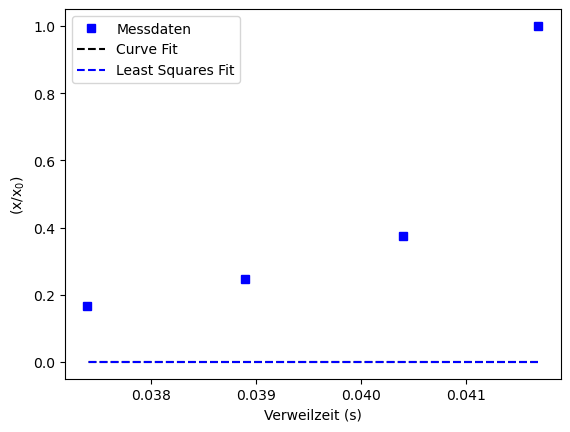

C:\Users\adako\AppData\Local\Temp\ipykernel_14880\1415417753.py:113: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(1000 / all_temp, np.log10(-np.log(all_x) / all_times), "bs", label="Messdaten")


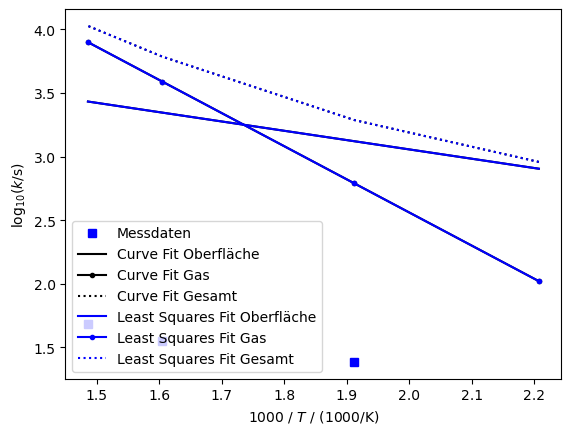

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, least_squares
import pandas as pd
import warnings

# Seed for reproducibility
np.random.seed(123)

# Daten einlesen
fn = "kineticsAlAcAc_dm_0"
dat0 = pd.read_excel("Kin_Fit_Test.xlsx")
dat0.columns = dat0.columns.str.strip()
print("Spaltennamen:", dat0.columns.tolist())
anfang = 0
ende = 4
all_temp = dat0['T'].values[anfang:ende]
all_times = dat0['MeanTime (ms)'].values[anfang:ende] / 1000
all_x = (dat0['X'] / dat0['X'][0]).values[anfang:ende]


# Parameter als Dictionary (Skalierung für bessere Stabilität)
parameters = {
    "As": 3.3e4,
    "Eas": 1.4e4,
    "Ag": 5.8e7,
    "Eag": 4.98e4
}


# Arrhenius-Funktion
def k_arrhenius(A, Ea, T):
    return A * np.exp(-Ea / (8.314 * T))


# x_t Funktion mit Interpolation
def x_t(t, As, Eas, Ag, Eag):
    temp = np.interp(t, all_times, all_temp)
    return np.exp(-t * (k_arrhenius(As, Eas, temp) + k_arrhenius(Ag, Eag, temp)))


# Least-Squares Funktion
def xt_ls(para, t, x, temp):
    As, Eas, Ag, Eag = para
    x_c = np.exp(-t * (k_arrhenius(As, Eas, temp) + k_arrhenius(Ag, Eag, temp)))
    return x - x_c


# Kovarianz und Fehleranalyse
def calculate_covariance(loesls, num_params, num_meas):
    RSS = sum(loesls.fun ** 2)
    SER = np.sqrt(RSS / (num_meas - num_params))
    q, r = np.linalg.qr(loesls.jac)
    r_inv = np.linalg.pinv(r)
    jtj_inv = np.matmul(r_inv, r_inv.T)
    return SER ** 2 * jtj_inv, SER

lower_bounds = [1e3, 1e4, 1e6, 4e4]    # Untere Grenzen der Parameter [As, Eas, Ag, Eag]
upper_bounds = [1e6, 5e4, 1e9, 8e4]    # Obere Grenzen der Parameter [As, Eas, Ag, Eag]

# Fit-Berechnung und Ausgabe der Ergebnisse
initial_params = list(parameters.values())
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    curve_fit_params, curve_fit_cov = curve_fit(x_t, all_times, all_x, p0=initial_params, bounds=(lower_bounds,upper_bounds))

# Ergebnis des Curve Fit prüfen
print("Curve Fit Ergebnisse:")
if curve_fit_cov is not None:
    As, Eas, Ag, Eag = curve_fit_params
    print(f"Oberfläche: A = {As:.2e}, Ea = {Eas:.2e}")
    print(f"Gasphase: A = {Ag:.2e}, Ea = {Eag:.2e}")
    stdev = np.sqrt(np.diag(curve_fit_cov))
    print("Sigma (Curve Fit):", stdev)
else:
    print("Curve Fit Kovarianz konnte nicht berechnet werden.")

# Least Squares Fit und Ergebnisse
least_squares_result = least_squares(xt_ls, initial_params,bounds=(lower_bounds, upper_bounds), loss='linear', method='trf',
                                     args=(all_times, all_x, all_temp),)
print("\nLeast Squares Fit Ergebnisse:")
As_ls, Eas_ls, Ag_ls, Eag_ls = least_squares_result.x
print(f"Oberfläche: A = {As_ls:.2e}, Ea = {Eas_ls:.2e}")
print(f"Gasphase: A = {Ag_ls:.2e}, Ea = {Eag_ls:.2e}")

# Kovarianz und Fehlerberechnung für Least Squares
cov_matrix, ser = calculate_covariance(least_squares_result, len(initial_params), len(all_temp))
std_residuals = np.sqrt(np.diag(cov_matrix))
print("Kovarianzmatrix (Least Squares Fit):\n", cov_matrix)
print("Standardabweichungen (Least Squares Fit):", std_residuals)
print("Standardfehler der Regression (SER):", ser)

# Korrelationsmatrix berechnen und anzeigen
print("\nKorrelationsmatrix:")
for i in range(4):
    for j in range(i):
        correlation = cov_matrix[i, j] / (std_residuals[i] * std_residuals[j])
        print(f"Parameter {j} und {i}: {correlation:.3f}")

# Plot der Ergebnisse
fig1, ax1 = plt.subplots()
ax1.plot(all_times, all_x, "bs", label="Messdaten")
ax1.plot(all_times, x_t(all_times, *curve_fit_params), "k--", label="Curve Fit")
ax1.plot(all_times, x_t(all_times, *least_squares_result.x), "b--", label="Least Squares Fit")
ax1.set_xlabel("Verweilzeit (s)")
ax1.set_ylabel("(x/x$_0$)")
ax1.legend()
fig1.savefig(fn + "_x-T.png")
plt.show()

# Arrhenius-Plot
fig2, ax2 = plt.subplots()
ax2.plot(1000 / all_temp, np.log10(-np.log(all_x) / all_times), "bs", label="Messdaten")


def plot_arrhenius(ax, params, color, label):
    As, Eas, Ag, Eag = params
    ks = np.log10(k_arrhenius(As, Eas, all_temp))
    kg = np.log10(k_arrhenius(Ag, Eag, all_temp))
    k_tot = np.log10(k_arrhenius(Ag, Eag, all_temp) + k_arrhenius(As, Eas, all_temp))

    ax.plot(1000 / all_temp, ks, color + "-", label=f"{label} Oberfläche")
    ax.plot(1000 / all_temp, kg, color + ".-", label=f"{label} Gas")
    ax.plot(1000 / all_temp, k_tot, color + ":", label=f"{label} Gesamt")


plot_arrhenius(ax2, curve_fit_params, "k", "Curve Fit")
plot_arrhenius(ax2, least_squares_result.x, "b", "Least Squares Fit")
ax2.set_xlabel("1000 / $T$ / (1000/K)")
ax2.set_ylabel("log$_{10}(k /$s)")
ax2.legend()
fig2.savefig(fn + "_Arrhenius.png")
plt.show()

